## 0. Loading data from remote Drive

In [2]:
from google.colab import drive
import os

print('Mounting Google Drive...')
drive.mount('/gdrive')

src_path = '/gdrive/MyDrive/shortcuts/project' #@param {type: 'string'}
assert os.path.exists(src_path), f"Source '{src_path}' doesn't exist!"

target_path = '.' #@param {type: 'string'}
os.makedirs(target_path, exist_ok=True)
assert os.path.exists(target_path), f"Target '{target_path}' doesn't exist!"

target_path = os.path.join(target_path, os.path.basename(src_path))
print(f'Copying from "{src_path}" to "{target_path}"...')
os.makedirs(target_path, exist_ok=True)
!cp -rf "$src_path"/* "$target_path"  # also work when source is a shortcut

Mounting Google Drive...
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Copying from "/gdrive/MyDrive/shortcuts/project" to "./project"...


In [3]:
!sudo tar -xvf  project/* 
pass

BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
BSR/bench/source/Matrix.hh
BSR/bench/source/csa.hh
BSR/bench/source/String.hh
BSR/bench/bench_bsds500.m
BSR/bench/data/
BSR/bench/data/groundTruth/
BSR/bench/data/groundTruth/6046.mat
BSR/bench/data/groundTruth/2018.mat
BSR/bench/data/groundTruth/8068.mat
BSR/bench/

## 1. Preparing data for augumentation

In [4]:
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as TT
import torch

import numpy as np

from PIL import Image

import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
train_path = 'BSR/BSDS500/data/images/train/'
test_path = 'BSR/BSDS500/data/images/test/'
val_path = 'BSR/BSDS500/data/images/test/'

We were told to use 432 pics for train and 68 for validation, so let's aggregate that data from available ``train``, ``test`` and ``val`` directories(each of those has 201 pics inside)

In [6]:
TRAIN_SIZE = 432
VAL_SIZE = 68

Aggregate ***training***

In [7]:
train_pics_list = []

for pic_name in os.listdir(train_path):
    if pic_name.split('.')[-1] == 'jpg':
        train_pics_list.append(train_path + pic_name)

for pic_name in os.listdir(test_path):
    if pic_name.split('.')[-1] == 'jpg':
        train_pics_list.append(test_path + pic_name)

val_pics_for_train = []

for pic_name in os.listdir(val_path):

    if len(val_pics_for_train) == TRAIN_SIZE - len(train_pics_list):
        break
    
    if pic_name.split('.')[-1] == 'jpg':
        val_pics_for_train.append(val_path + pic_name)

train_pics_list += val_pics_for_train

assert len(train_pics_list) == TRAIN_SIZE

Aggregate ***validation***

In [8]:
val_pics_list = []

remaining_pics_list = []

for pic_name in os.listdir(val_path):

    if len(val_pics_list) == VAL_SIZE:
        break
    
    if pic_name.split('.')[-1] == 'jpg':
        val_pics_list.append(val_path + pic_name)

assert len(val_pics_list) == VAL_SIZE

In [9]:
class BSDDataset(torch.utils.data.Dataset):
  def __init__(self, img_list, transform):
    super(BSDDataset, self).__init__()
    self.img_list = img_list
    self.transform = transform

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    img = Image.open(self.img_list[idx])
    return self.transform(img)

## 2. Augumentation

In [10]:
random_transform = [
    TT.Compose([TT.RandomCrop(320, padding=0),
                        TT.Pad(2, padding_mode='reflect')]),
    TT.Compose([TT.RandomCrop(320, padding=0), 
            ]),
]

train_transform = TT.Compose([
    TT.RandomHorizontalFlip(p=0.5), 
    TT.RandomRotation(degrees=10),
    TT.RandomChoice(random_transform),
    TT.RandomChoice(random_transform),
    TT.Resize((321, 481)),
    TT.ToTensor(), 
    TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = TT.Compose([
    TT.Resize((321, 481)),
    TT.ToTensor(),
    TT.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = BSDDataset(train_pics_list, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)

val_set = BSDDataset(val_pics_list, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32)

print('Train size', len(train_set))
print('Test size', len(val_set))

Train size 432
Test size 68


In [11]:
def plot_random_images(loader):

    n_images = 5

    _, axes = plt.subplots(figsize=(20, 5), ncols=n_images)

    model_input = iter(loader).next()

    for img_id, ax in zip(np.random.choice(model_input.shape[0], n_images, replace=False), axes.ravel()):
    
        # proccess the image
        image = model_input[img_id]/2 + 0.5 # inverse normalize
        image = image.cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")

        ax.imshow(image)
    
        ax.axis('off')

    plt.tight_layout()

Train (augmented) images.


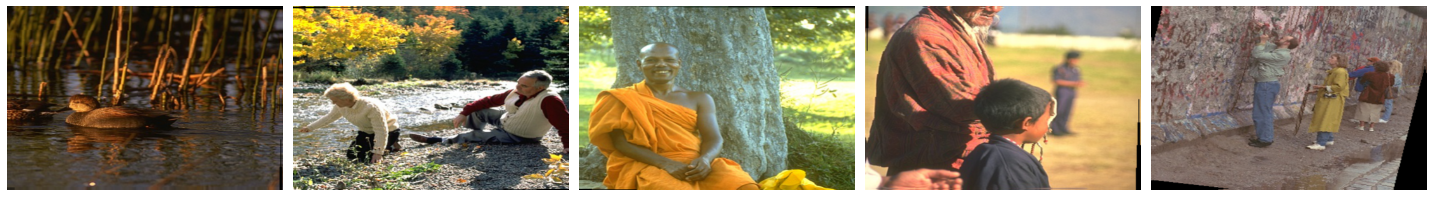

In [12]:
print('Train (augmented) images.')

plot_random_images(train_loader)

Test images (no augmentation).


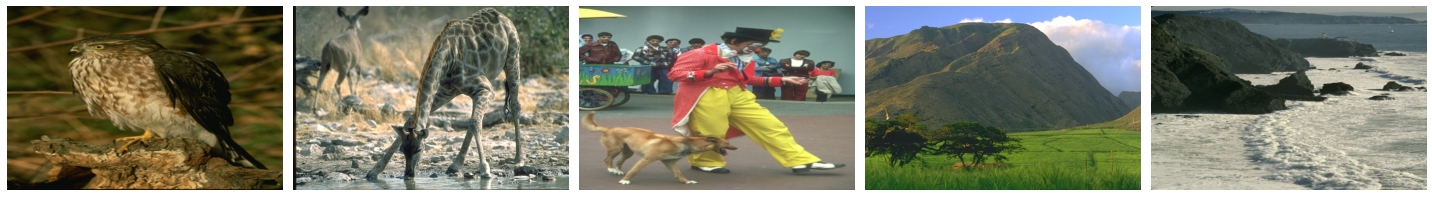

In [13]:
print('Test images (no augmentation).')
plot_random_images(val_loader)